# Notebook to make TS diagrams for the control volume outlined in 'overview_figure.ipynb'
The goal here is to see if the TXLA model and observations are similar. We will use xhistogram as the primary package for analysis. 
> - Calculate a 2D joint probability density function, aka a TS diagram for the nested child model. We do this because there are far too many points to put on a scatterplot. $n = 96*30*600^2$, $f(t,z,y,x)$, there are ~600-700 xi_rho and eta_points
> - Calculate the mean dissipation of total kinetic energy $\epsilon$ in each TS bin. See ```calc_epsilon.ipynb``` for more information

In [2]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
import pandas as pd
import gsw as gsw

### Open model output 

In [3]:
paths = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child_*.nc')
ds = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, Vtransform = 2)

### Prepare variables for binning 
> - Remove the grid attribute, give each dataarray a name. Otherwise this will raise an error code when either doing a computation or saving to a .nc file. 
> - Do the calculations for two cases: all depths, and depths excluding z>-1 m. The latter is to partially remove the surface temperature stratification.
> > - Subset the variable and save them to a .nc for faster computation of the histograms. Otherwise this will be very slow

In [5]:
def calc_epsilon(ds, grid):
    '''
Function to calculate TKE dissipation rate for GLS models based on Eq. 12 of Warner
et al. (2005) ocean modeling
    '''
    cmu0 = ds.gls_cmu0
    gls_m = ds.gls_m
    gls_n = ds.gls_n
    gls_p = ds.gls_p

    tke = ds.tke
    gls = ds.gls
    
    epsilon_w = cmu0**(3.0+gls_p/gls_n) * tke**(3.0/2.0+gls_m/gls_n) * gls**(-1.0/gls_n)
    epsilon = grid.interp(epsilon_w, 'Z') #Interpolate to the w points 
    return epsilon
  
# Box for the location of the cruise
lon = np.array([-92.6,-92])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

tslice = slice('2022-07-03','2022-07-05 2:00')

z = ds.z_rho.where(box).sel(ocean_time=tslice)

salt = ds.salt.where(box).sel(ocean_time=tslice)
saltz = salt.where(z<-1)
saltz.attrs = ''
saltz.name = 'salt'

salt.attrs = ''
salt.name = 'salt'

temp = ds.temp.where(box).sel(ocean_time=tslice)
tempz = temp.where(z<-1)
tempz.attrs = ''
tempz.name = 'temp'

temp.attrs = ''
temp.name = 'temp'

dV = ds.dV.where(box).sel(ocean_time=tslice)
dVz = dV.where(z<-1)
dVz.attrs = ''
dVz.name = 'dV'

dV.attrs = ''
dV.name = 'dV'

eps = calc_epsilon(ds, grid)
eps = eps.where(box).sel(ocean_time=tslice)
epsz = eps.where(z<-1)
epsz.attrs = ''
epsz.name = 'eps'

eps.attrs = ''
eps.name = 'eps'

#Merge the variables and save them as a netcdf 
ds_all = xr.merge([salt,temp,eps,dV], compat = 'override')
ds_z1 = xr.merge([saltz,tempz,epsz,dVz], compat = 'override')

# ds_all.to_netcdf('ts_histograms_nested_all_z_2022.nc')
# ds1.to_netcdf('ts_histograms_nested_2022.nc')

### Use the GSW toolbox to get the isopycnals for plotting. 
Comment this out after running 

In [ ]:
# tslice = slice('2022-07-03','2022-07-05 12:00')
# temp = ds.temp.where(box).sel(ocean_time=tslice)
# salt = ds.salt.where(box).sel(ocean_time=tslice)

# # Need to get the extrema to find the range.
# # Stack the values and remove the nans. This loads them into memory, very slow.
# start = time.process_time()
# tempstack = temp.stack(z=['xi_rho','eta_rho', 'ocean_time','s_rho']).values  
# print(time.process_time() - start)
# saltstack = salt.stack(z=['xi_rho','eta_rho', 'ocean_time','s_rho']).values
# print(time.process_time() - start)

# #Calculate the extrema
# t_min = np.nanmin(tempstack) - 1
# t_max = np.nanmax(tempstack) + 1
# s_min = np.nanmin(saltstack) - 1
# s_max = np.nanmax(saltstack) + 1
# print(t_min)
# print(t_max)
# print(s_min)
# print(s_max)

# # Calculate how many gridcells we need in the x and y dimensions
# xdim = np.ceil(s_max - s_min)/0.1
# ydim = np.ceil(t_max-t_min)
# dens = np.zeros((int(ydim),int(xdim)))

# # Create temp and salt vectors of appropiate dimensions
# ti = np.linspace(0,int(ydim),int(ydim))+t_min
# si = np.linspace(1,int(xdim),int(xdim))*0.1+s_min

# # Loop to fill in grid with densities
# for j in range(0,int(ydim)):
#     for i in range(0, int(xdim)):
#         dens[j,i]=gsw.rho(si[i],ti[j],0)

# # Subtract 1000 to convert to sigma-t
# dens = dens - 1000

# # np.save('density_lines_ts.npy',dens)
# # np.save('salt_lines_ts.npy',si)
# # np.save('temp_lines_ts.npy',ti)

### Open the subsetted output and compute the histograms

In [8]:
si = np.load('salt_lines_ts.npy')
ti = np.load('temp_lines_ts.npy')
dens = np.load('density_lines_ts.npy')

ts1 = xr.open_dataset('ts_histograms_nested_all_z_2022.nc')
ts2 = xr.open_dataset('ts_histograms_nested_2022.nc')
ts = [ts1,ts2]

In [15]:
tempbins = np.linspace(25,40.1,201)
saltbins = np.linspace(22,36,201)

eps_hist = []
ts_hist1 = []
for i in range(2):
    tshist_eps1 = histogram(ts[i].salt,ts[i].temp,
                            bins=[saltbins,tempbins],
                            weights = ts[i].eps*ts[i].dV,
                            dim=['xi_rho','eta_rho','ocean_time','s_rho'],
                            block_size=len(ts[i].salt.ocean_time), density=False).compute()

    tshist_eps2 = histogram(ts[i].salt,ts[i].temp,
                            bins=[saltbins,tempbins],
                            weights = ts[i].dV,
                            dim=['xi_rho','eta_rho','ocean_time','s_rho'],
                            block_size=len(ts[i].salt.ocean_time), density=False).compute()

    eps_avg = tshist_eps1/tshist_eps2
    
    ts_hist = histogram(ts[i].salt,ts[i].temp,
                        bins=[saltbins,tempbins],
                        dim=['xi_rho','eta_rho','ocean_time','s_rho'],
                        block_size=len(ts[i].salt.ocean_time), density=True).compute()
    
    eps_hist.append(eps_avg)
    ts_hist1.append(ts_hist)

### Calculate and load in isopycnals for plotting the TS diagrams 

/tmp/ipykernel_7649/2281357635.py:23: UserWarning: The following kwargs were not used by contour: 'manual'
  CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)


Text(0.5, 1.0, '$z<-1$ m')

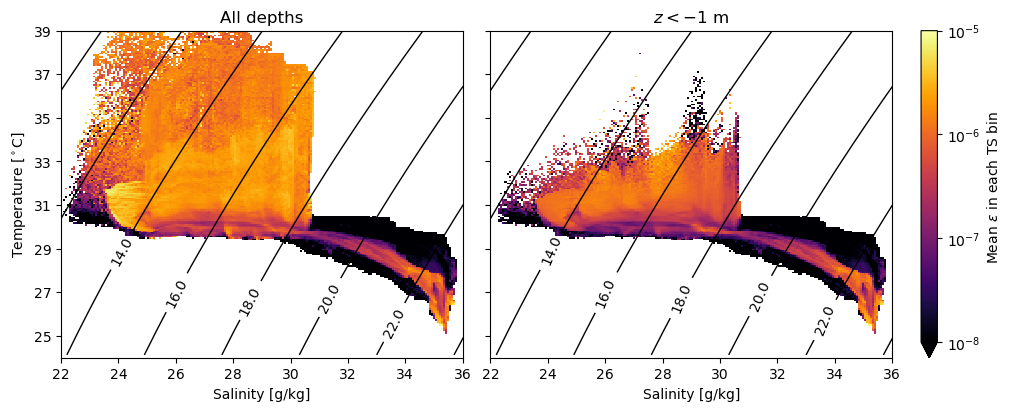

In [41]:
plt.ion()
fig, ax = plt.subplots(1,2, figsize = (10,4), constrained_layout=True, sharex=True,sharey=True)

m = np.log10(eps_hist[0].T).plot(ax=ax[0],cmap = plt.get_cmap('inferno'), vmin = -8, vmax = -5, add_colorbar = False)
m = np.log10(eps_hist[1].T).plot(ax=ax[1],cmap = plt.get_cmap('inferno'), vmin = -8, vmax = -5, add_colorbar = False)
plt.xlim(22,36)
plt.ylim(24,39)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)

plt.clabel(CS, fontsize=10, inline=1, fmt='%.1f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
# plt.show()
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33])

cbar = fig.colorbar(m, ax = ax[1], 
                    label = r'Mean $\epsilon$ in each TS bin', 
                    ticks = [-8,-7,-6,-5,-4], 
                    format=tick.FormatStrFormatter('$10^{%d}$'),
                    extend = 'min')

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.1f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29,31,33,35,37,39])

ax[0].set_title('All depths')
ax[1].set_title('$z<-1$ m')
# plt.savefig('ts_diagram.jpg',dpi = 300)

### Load in the observational data. 
It's formatted in a .mat file, so we need to figure out how this works. Try this code from stack exchange, didn't change a thing. Need to slice in time for the student cruise. Brute force, no way around it

In [12]:
from scipy.io import loadmat, matlab
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray

    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)

data = load_mat('vmp_alldata_PE_PS.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu May 18 08:58:49 2023',
 '__version__': '1.0',
 '__globals__': [],
 'vmp_bin': {'DO2A': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'DO2R': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'Fl': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
 

In [13]:
dn = data['vmp_bin']['dn']
dn1 = data['vmp_binSP']['dn']

#Check the times manually by hand 
time = pd.to_datetime(dn-719529, unit='D') # Stack exchange saving me again 
time1 = pd.to_datetime(dn1-719529, unit='D') # Stack exchange saving me again 

time[9685:11500]

DatetimeIndex(['2022-07-03 00:00:25.028651264',
               '2022-07-03 00:02:06.430092800',
               '2022-07-03 00:03:53.425871360',
               '2022-07-03 00:05:35.889930240',
               '2022-07-03 00:07:19.463468288',
               '2022-07-03 00:08:20.264003584',
               '2022-07-03 00:09:02.927632384',
               '2022-07-03 00:09:44.319844096',
               '2022-07-03 00:11:29.815469824',
               '2022-07-03 00:13:13.342136320',
               ...
               '2022-07-05 01:52:37.035075584',
               '2022-07-05 01:53:54.887127552',
               '2022-07-05 01:55:11.879719424',
               '2022-07-05 01:56:28.700405248',
               '2022-07-05 01:57:45.739868672',
               '2022-07-05 01:59:03.748196096',
               '2022-07-05 02:00:25.678801920',
               '2022-07-05 02:01:46.109254912',
               '2022-07-05 02:03:06.149043968',
               '2022-07-05 02:04:29.204769280'],
              dtype=

In [87]:
S = data['vmp_bin']['SA'][:,9685:11500]
T = data['vmp_bin']['theta'][:,9685:11500]
E = data['vmp_bin']['epsi'][:,9685:11500]

S1 = data['vmp_binSP']['SA'][:,5909:7020]
T1 = data['vmp_binSP']['theta'][:,5909:7020]
E1 = data['vmp_binSP']['epsi'][:,5909:7020]

### Plot the top 1 m removed and the entire water column.
Repeat this for the epsilon cases as well

/tmp/ipykernel_7649/2624087224.py:19: UserWarning: The following kwargs were not used by contour: 'manual'
  CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)


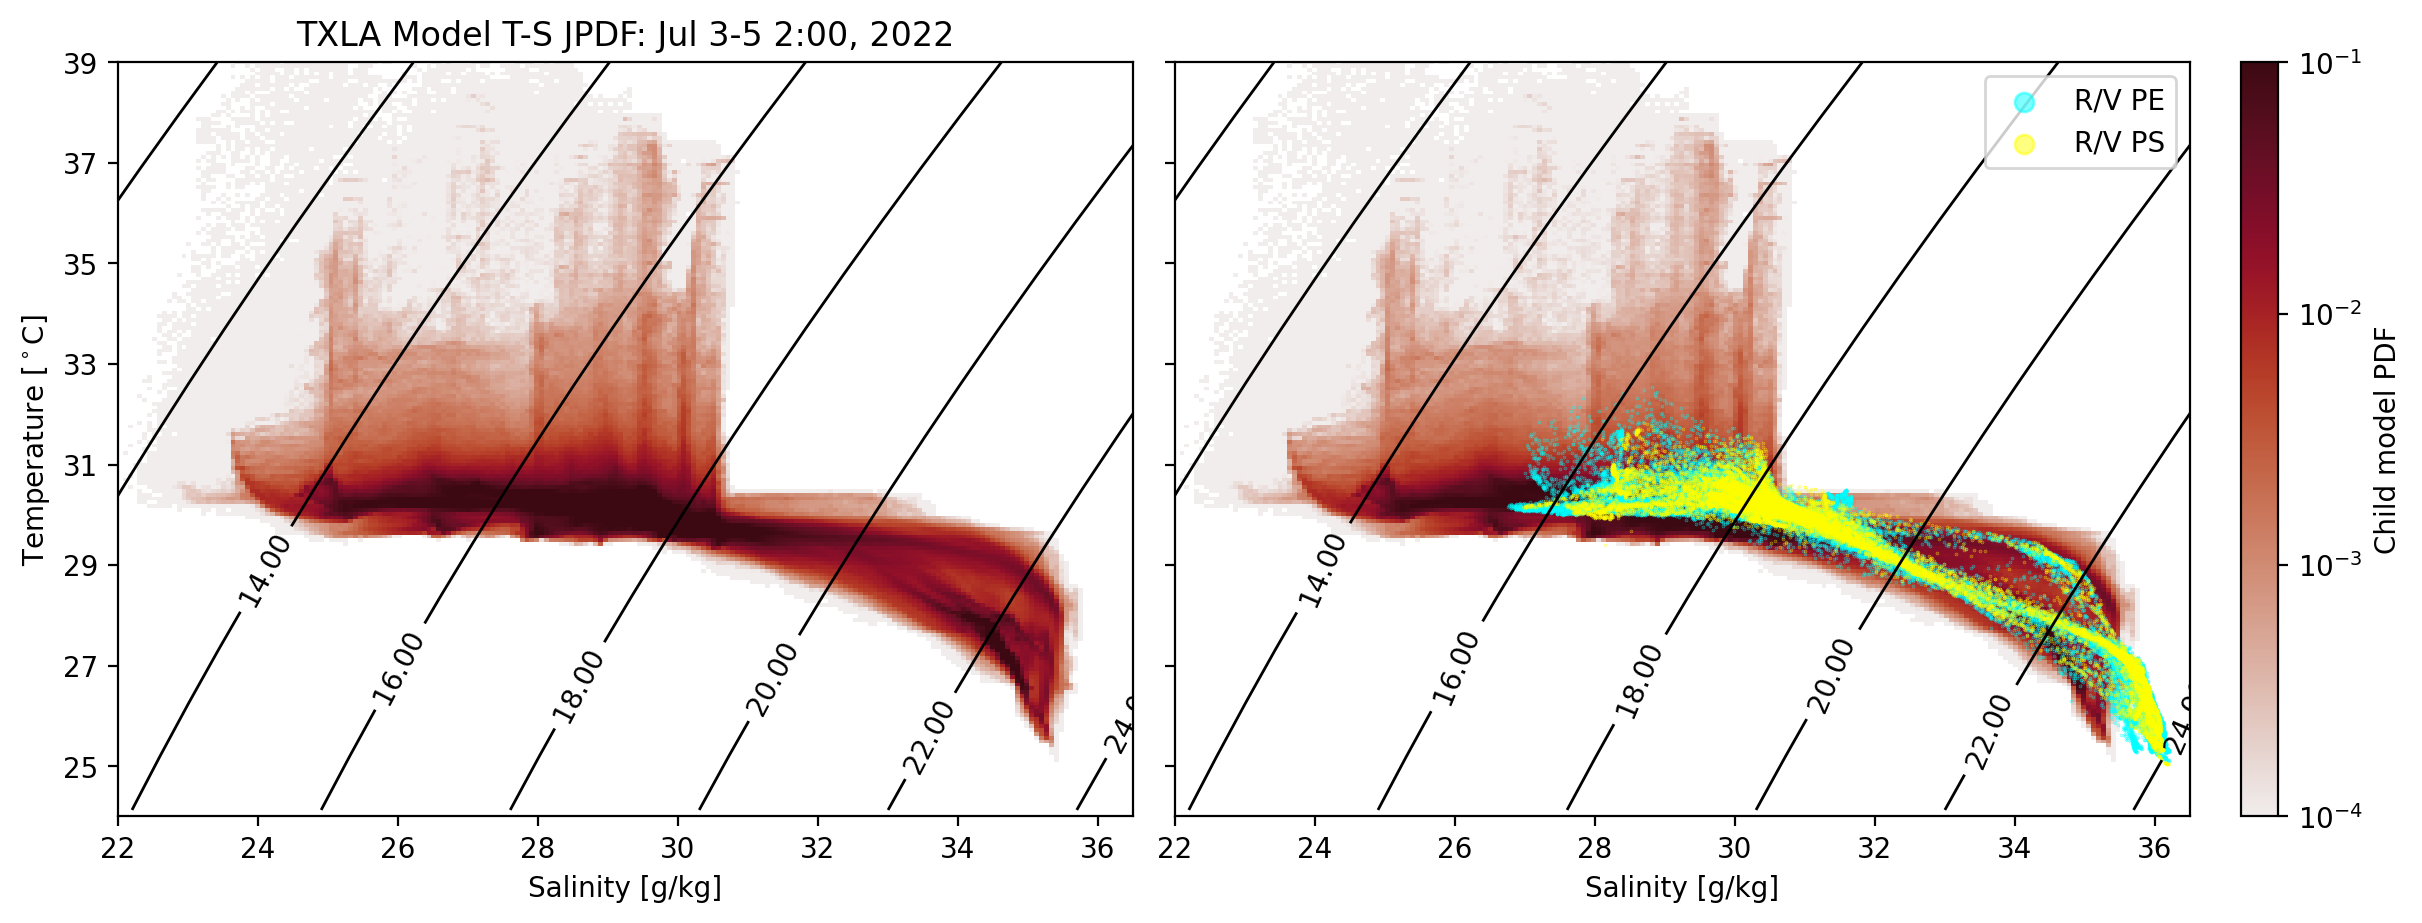

In [43]:
plt.ion()
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True,dpi=200)

m = np.log10(ts_hist1[0].T).plot(ax=ax[0],cmap = cmo.amp, vmin = -4, vmax = -1, add_colorbar = False)
m = np.log10(ts_hist1[0].T).plot(ax=ax[1],cmap = cmo.amp, vmin = -4, vmax = -1, add_colorbar = False)
plt.xlim(22,36.5)
plt.ylim(24,39)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)

plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
# plt.show()
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29,31,33,35,37,39])

cbar = fig.colorbar(m, ax = ax[1], label = r'Child model PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29,31,33,35,37,39])

plt.scatter(S,T,s=0.075, c = 'cyan', alpha = 0.5, label = r'R/V PE')
plt.scatter(S1,T1,s=0.075, c = 'yellow', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('TXLA Model T-S JPDF: Jul 3-5 2:00, 2022')
plt.legend(markerscale=25)
# plt.savefig('ts_diagram_cruise_SA.jpg',dpi = 300)

/tmp/ipykernel_7649/2874875216.py:21: UserWarning: The following kwargs were not used by contour: 'manual'
  CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)


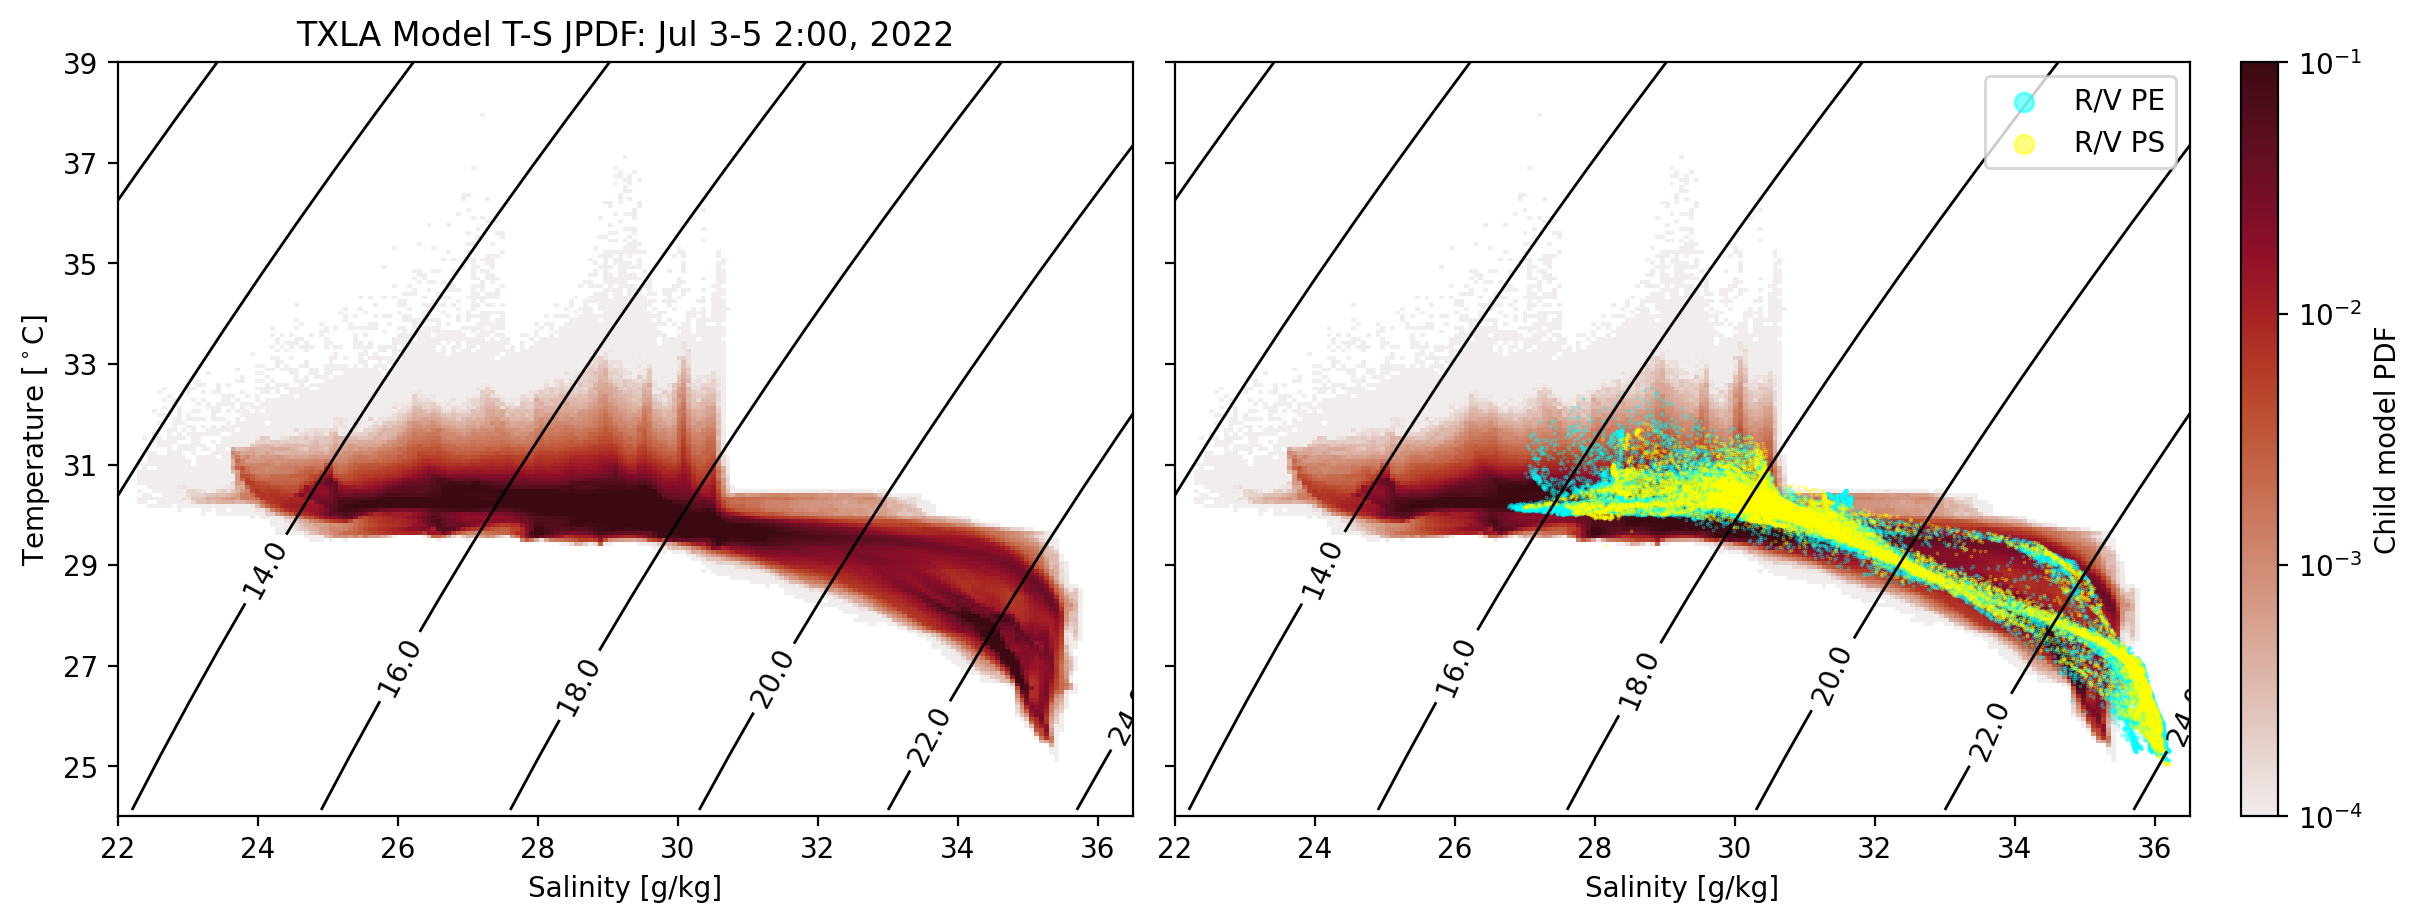

In [125]:
plt.ion()
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True,dpi=200)

m = np.log10(ts_hist1[1].T).plot(ax=ax[0],cmap = cmo.amp, vmin = -4, vmax = -1, add_colorbar = False)
m = np.log10(ts_hist1[1].T).plot(ax=ax[1],cmap = cmo.amp, vmin = -4, vmax = -1, add_colorbar = False)
# plt.xlim(23.5,37)
# plt.ylim(25,33)
plt.xlim(22,36.5)
plt.ylim(24,39)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)

plt.clabel(CS, fontsize=10, inline=1, fmt='%.1f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
# plt.show()
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29,31,33,35,37,39])

cbar = fig.colorbar(m, ax = ax[1], label = r'Child model PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.1f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29,31,33,35,37,39])

plt.scatter(S,T,s=0.075, c = 'cyan', alpha = 0.5, label = r'R/V PE')
plt.scatter(S1,T1,s=0.075, c = 'yellow', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('TXLA Model T-S JPDF: Jul 3-5 2:00, 2022')
plt.legend(markerscale=25)
# plt.savefig('ts_diagram_cruise_SA.jpg',dpi = 300)

/tmp/ipykernel_7649/746379457.py:23: UserWarning: The following kwargs were not used by contour: 'manual'
  CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
/tmp/ipykernel_7649/746379457.py:32: RuntimeWarning: divide by zero encountered in log10
  t = ax[1].scatter(S,T,s=0.075, c = np.log10(E), cmap = plt.get_cmap('cmo.matter'), label = r'R/V PE')


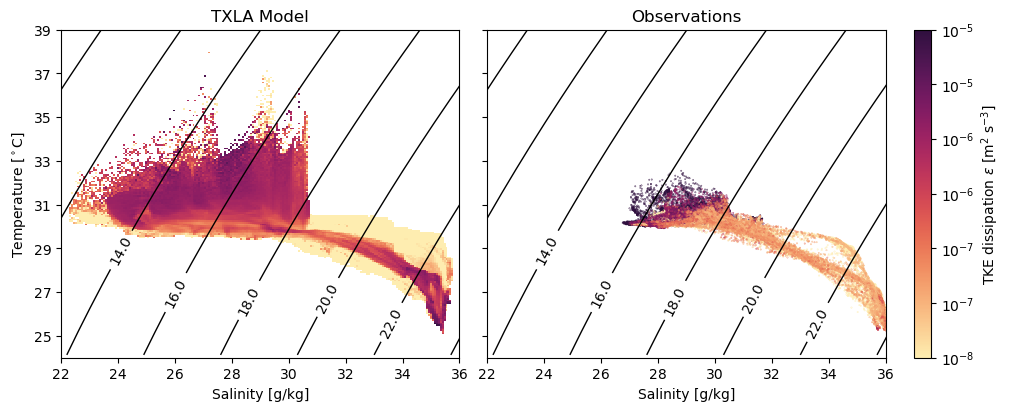

In [123]:
plt.ion()
fig, ax = plt.subplots(1,2, figsize = (10,4), constrained_layout=True, sharex=True,sharey=True)

m = np.log10(eps_hist[1].T).plot(ax=ax[0],cmap = plt.get_cmap('cmo.matter'), vmin = -8, vmax = -5, add_colorbar = False)
# m = np.log10(eps_hist[1].T).plot(ax=ax[1],cmap = plt.get_cmap('inferno'), vmin = -8, vmax = -5, add_colorbar = False)
plt.xlim(22,36)
plt.ylim(24,39)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)

plt.clabel(CS, fontsize=10, inline=1, fmt='%.1f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
# plt.show()
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33])

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.1f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29,31,33,35,37,39])

ax[0].set_title('TXLA Model')
ax[1].set_title('Observations')

t = ax[1].scatter(S,T,s=0.075, c = np.log10(E), cmap = plt.get_cmap('cmo.matter'), label = r'R/V PE')
t1 = ax[1].scatter(S1,T1,s=0.075, c = np.log10(E1), cmap = plt.get_cmap('cmo.matter'), label = r'R/V PE')
c = fig.colorbar(t, format=tick.FormatStrFormatter('$10^{%d}$'), label = 'TKE dissipation $\epsilon$ [m$^2$ s$^{-3}$]')
t.set_clim(vmin = -8, vmax = -5)
# plt.savefig('ts_diagram.jpg',dpi = 300)

### Unsurpisingly, the model an observed values do not compare well. 
Investigate this more in the future 